In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
from IPython.display import display
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
data = pd.read_csv("Daily_Demand_Forecasting_Orders.csv", sep=";")
data.head(10)
y = data.iloc[:,-1]
X = data.drop(data.columns[-1], axis=1)
display(X.head(10))
display(y.head(10))

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257
5,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966
6,2,5,144.124,118.919,43.304,66.371,153.368,0.000,46573,33597,48269,20973
7,2,6,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,56665,18502
8,3,2,218.856,124.381,33.973,148.274,162.044,1.054,66612,19461,103376,10458
9,3,3,146.518,101.045,36.399,43.306,168.723,865.000,58224,7742,82395,11948


0    539.577
1    224.675
2    129.412
3    317.120
4    210.517
5    207.364
6    263.043
7    248.958
8    344.291
9    248.428
Name: Target (Total orders), dtype: float64

In [3]:
dummy = pd.DataFrame()
dummy["Nonurgent+urgent"] = X["Non-urgent order"]+X["Urgent order"]+X["Fiscal sector orders"]
dummy["order types"] = X["Order type A"]+X["Order type B"]+X["Order type C"]
dummy["sum"] = y
dummy.head(10)

,Nonurgent+urgent,order types,sum
0,539.577,539.577,539.577
1,224.675,224.675,224.675
2,129.412,129.412,129.412
3,317.120,317.120,317.120
4,210.517,210.517,210.517
5,286.285,207.364,207.364
6,263.043,263.043,263.043
7,248.958,248.958,248.958
8,344.291,344.291,344.291
9,1112.563,248.428,248.428


In [4]:
# apply onehot encoding to week and day numbers.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
dates = X.iloc[:,[0,1]]
encoded = enc.fit_transform(dates)
df_to_add = pd.DataFrame(encoded, columns=["W1", "W2", "W3", "W4", "W5", "Mon", "Tue", "Wed", "Thu", "Fri"])
# create new data frame by adding one-hot encoded data.
data_encoded = pd.concat([df_to_add, data.iloc[:, 2:]], axis=1)
X_encoded = data_encoded.drop(columns=data_encoded.columns[10:])
X_encoded.head(10)
corr = data_encoded.corr()
corr[corr.index == "Target (Total orders)"].transpose()

,Target (Total orders)
W1,-0.019427
W2,-0.228138
W3,0.059743
W4,0.007275
W5,0.215769
Mon,0.476413
Tue,0.017211
Wed,-0.112139
Thu,-0.151403
Fri,-0.211169


In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
f_regression_features = SelectKBest(f_regression, k="all").fit(X_encoded, y)
mut_info_features = SelectKBest(mutual_info_regression, k="all").fit(X_encoded, y)
a = pd.DataFrame(data={"Feature":X_encoded.columns, "P-value":f_regression_features.pvalues_}).sort_values(by="P-value")
b = pd.DataFrame(data={"Feature":X_encoded.columns, "Mut-info":mut_info_features.scores_}).sort_values(by="Mut-info", ascending=False)
feature_importance = pd.merge(a, b, on="Feature")
display(feature_importance)

,Feature,P-value,Mut-info
0,Mon,0.000119,0.205673
1,W2,0.079571,0.047509
2,W5,0.097773,0.061174
3,Fri,0.105313,0.007639
4,Thu,0.248186,0.030105
5,Wed,0.393633,0.000000
6,W3,0.650231,0.012470
7,W1,0.882875,0.000000
8,Tue,0.896156,0.015809
9,W4,0.956006,0.000000


### Linear Model
Ref: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.get_params

Average MSE of linear regression with all features from 5-fold cv:	8026.537
Average R2 of linear regression with all features from 5-fold cv:	-0.192
Best MSE: 6259.820749662732 with features: ('W2', 'Mon')
Best R2: 0.17911557434936917 with features: ('Mon',)
----------------------------------------------------------------
Selected features: ('W2', 'Mon')
MSE: 5647.893439124322
R2: 0.28459836125566207


<IPython.core.display.Javascript object>


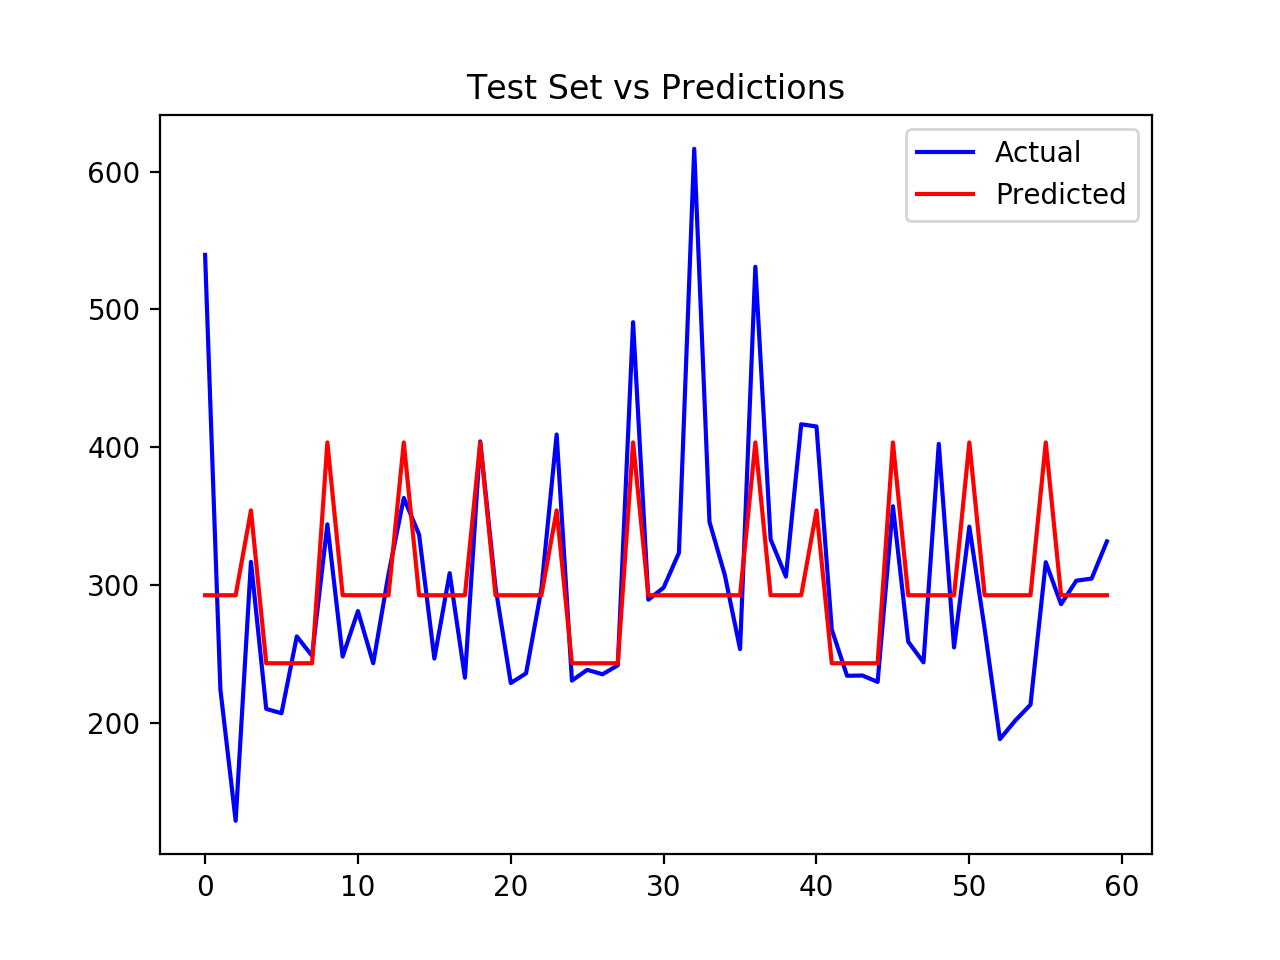

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
linear_reg = LinearRegression(fit_intercept=True)
# Use all the features
best_mse = cross_validate(linear_reg, X_encoded, y, cv=5, scoring=make_scorer(mean_squared_error), return_train_score=True)["test_score"].mean()
best_r2 = cross_validate(linear_reg, X_encoded, y, cv=5, scoring=make_scorer(r2_score), return_train_score=True)["test_score"].mean()
print("Average MSE of linear regression with all features from 5-fold cv:\t{:.3f}".format(best_mse))
print("Average R2 of linear regression with all features from 5-fold cv:\t{:.3f}".format(best_r2))

# Get all the combinations of the features
import itertools
feature_combinations = list()
for i in range(len(X_encoded.columns)+1):
    for item in itertools.combinations(X_encoded, i):
        feature_combinations.append(item)

# search over all the feature subsets
for subset in feature_combinations[1:]:
    X_train = X_encoded[list(subset)]
    mse = cross_validate(linear_reg, X_train, y, cv=5, scoring=make_scorer(mean_squared_error), return_train_score=True)["test_score"].mean()
    r2 = cross_validate(linear_reg, X_train, y, cv=5, scoring=make_scorer(r2_score), return_train_score=True)["test_score"].mean()
    if mse < best_mse:
        best_mse = mse
        best_mse_feat = subset
    if r2 > best_r2:
        best_r2 = r2
        best_r2_feat = subset
print("Best MSE: {} with features: {}".format(best_mse, best_mse_feat))
print("Best R2: {} with features: {}".format(best_r2, best_r2_feat))
print("----------------------------------------------------------------")
X_test = X_encoded[list(best_mse_feat)]
linear_reg.fit(X_test, y)
y_pred = linear_reg.predict(X_test)
print("Selected features: {}\nMSE: {}\nR2: {}".format(best_mse_feat, mean_squared_error(y, y_pred), r2_score(y, y_pred)))
x = list(range(y.shape[0]))
plt.plot(x, y, "b")
plt.plot(x, y_pred, "r")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])
plt.show()

Linear model shows a typical overfitting characteristics.
In order to prevent overfitting, regularization might be helpfull. Ridge regression adds regularization term.
### Ridge Regression
Ref: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

Best alpha with cross validation=5: 10
Average MSE of ridge regression with alpha=10 from 5-fold cv:	7351.041
Average R2 of linear regression with alpha=10 from 5-fold cv:	0.017
----------------------------------------------------------------
alpha: 10
MSE: 5940.4750986322515
R2: 0.2475379243096414


<IPython.core.display.Javascript object>


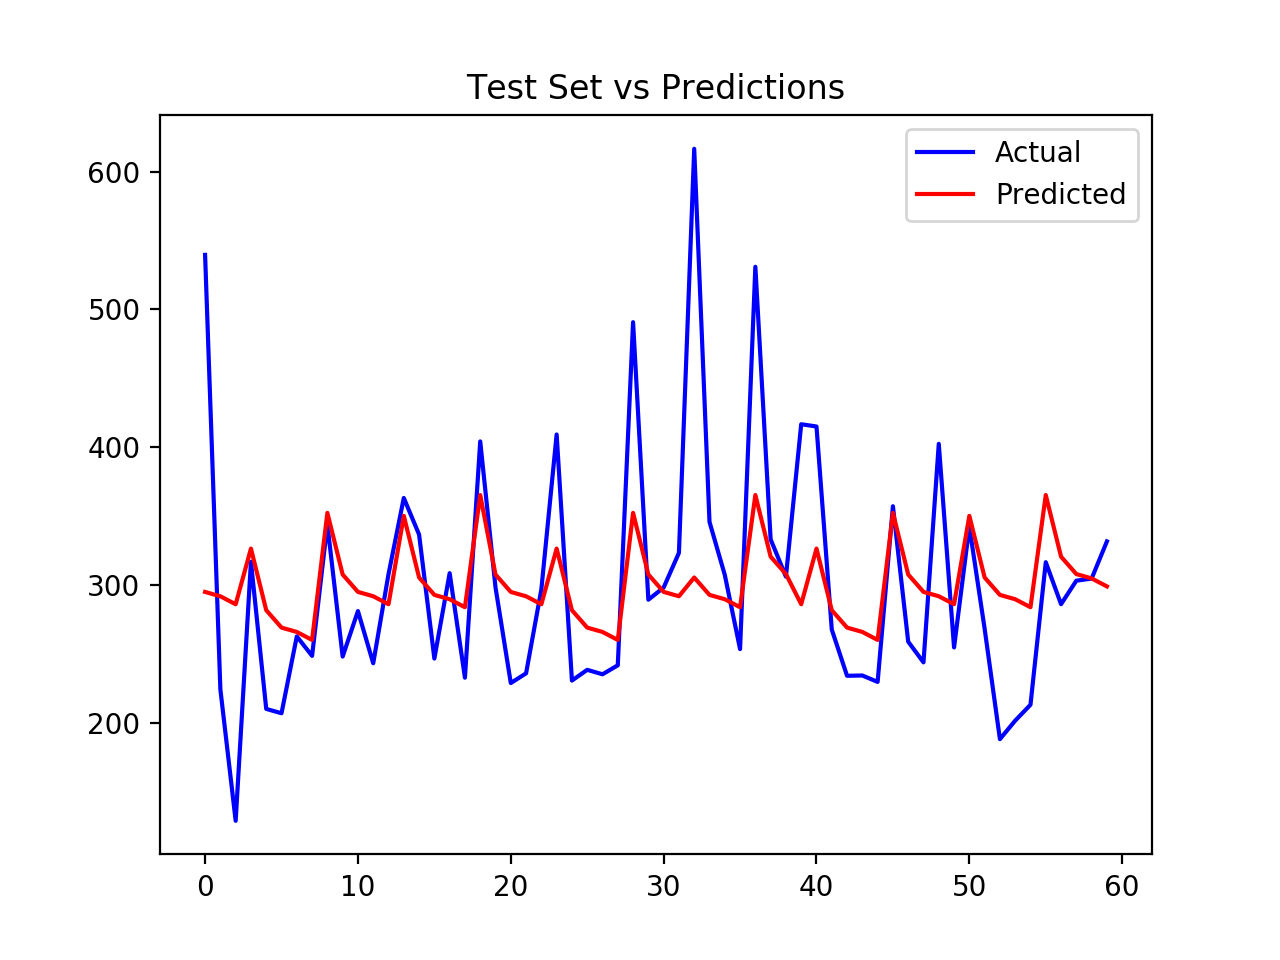

In [14]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
ridge_reg_cv = RidgeCV(alphas=[0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fit_intercept=True, cv=5)
ridge_reg_cv.fit(X_encoded, y)
print("Best alpha with cross validation=5: {}".format(ridge_reg_cv.alpha_))

ridge_reg = Ridge(alpha=ridge_reg_cv.alpha_, fit_intercept=True)
best_mse = cross_validate(ridge_reg, X_encoded, y, cv=5, scoring=make_scorer(mean_squared_error), return_train_score=True)["test_score"].mean()
best_r2 = cross_validate(ridge_reg, X_encoded, y, cv=5, scoring=make_scorer(r2_score), return_train_score=True)["test_score"].mean()
print("Average MSE of ridge regression with alpha=10 from 5-fold cv:\t{:.3f}".format(best_mse))
print("Average R2 of linear regression with alpha=10 from 5-fold cv:\t{:.3f}".format(best_r2))
print("----------------------------------------------------------------")
ridge_reg.fit(X_encoded, y)
y_pred = ridge_reg.predict(X_encoded)
print("alpha: {}\nMSE: {}\nR2: {}".format(ridge_reg_cv.alpha_, mean_squared_error(y, y_pred), r2_score(y, y_pred)))
x = list(range(y.shape[0]))
plt.plot(x, y, "b")
plt.plot(x, y_pred, "r")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])
plt.show()

### Lasso Regression

Best alpha with cross validation=5: 10.0
Average MSE of lasso regression with alpha=10 from 5-fold cv:	7284.907
Average R2 of linear regression with alpha=10 from 5-fold cv:	0.058
----------------------------------------------------------------
alpha: 10.0
MSE: 6770.7608464268405
R2: 0.14236813118223923


<IPython.core.display.Javascript object>


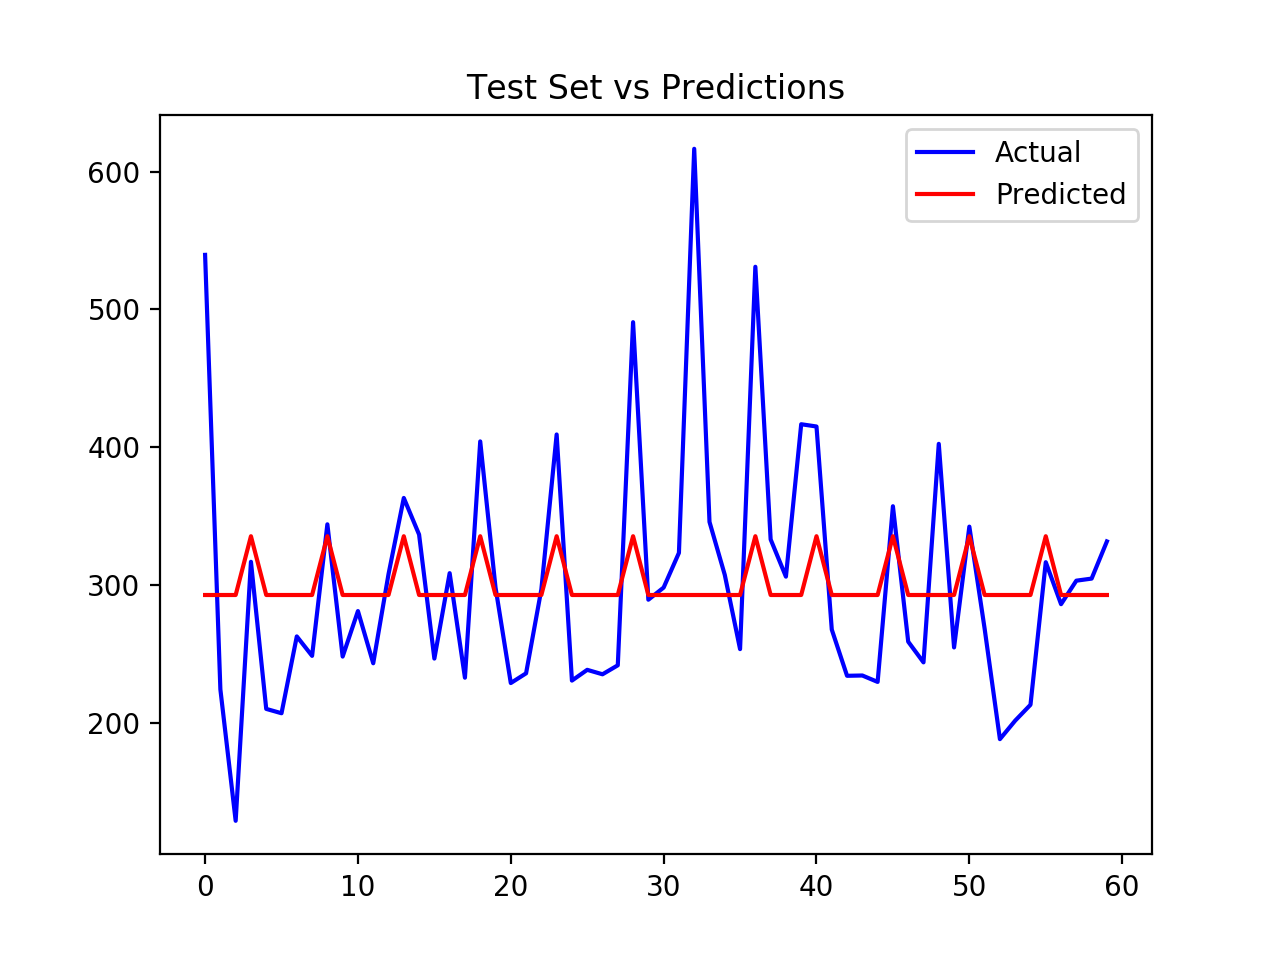

In [15]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
lasso_reg_cv = LassoCV(alphas=[0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fit_intercept=True, cv=5)
lasso_reg_cv.fit(X_encoded, y)
print("Best alpha with cross validation=5: {}".format(lasso_reg_cv.alpha_))

lasso_reg = Lasso(alpha=lasso_reg_cv.alpha_, fit_intercept=True)
best_mse = cross_validate(lasso_reg, X_encoded, y, cv=5, scoring=make_scorer(mean_squared_error), return_train_score=True)["test_score"].mean()
best_r2 = cross_validate(lasso_reg, X_encoded, y, cv=5, scoring=make_scorer(r2_score), return_train_score=True)["test_score"].mean()
print("Average MSE of lasso regression with alpha=10 from 5-fold cv:\t{:.3f}".format(best_mse))
print("Average R2 of linear regression with alpha=10 from 5-fold cv:\t{:.3f}".format(best_r2))
print("----------------------------------------------------------------")
lasso_reg.fit(X_encoded, y)
y_pred = lasso_reg.predict(X_encoded)
print("alpha: {}\nMSE: {}\nR2: {}".format(lasso_reg_cv.alpha_, mean_squared_error(y, y_pred), r2_score(y, y_pred)))
x = list(range(y.shape[0]))
plt.plot(x, y, "b")
plt.plot(x, y_pred, "r")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])
plt.show()

### Decision Tree Regressor

<IPython.core.display.Javascript object>


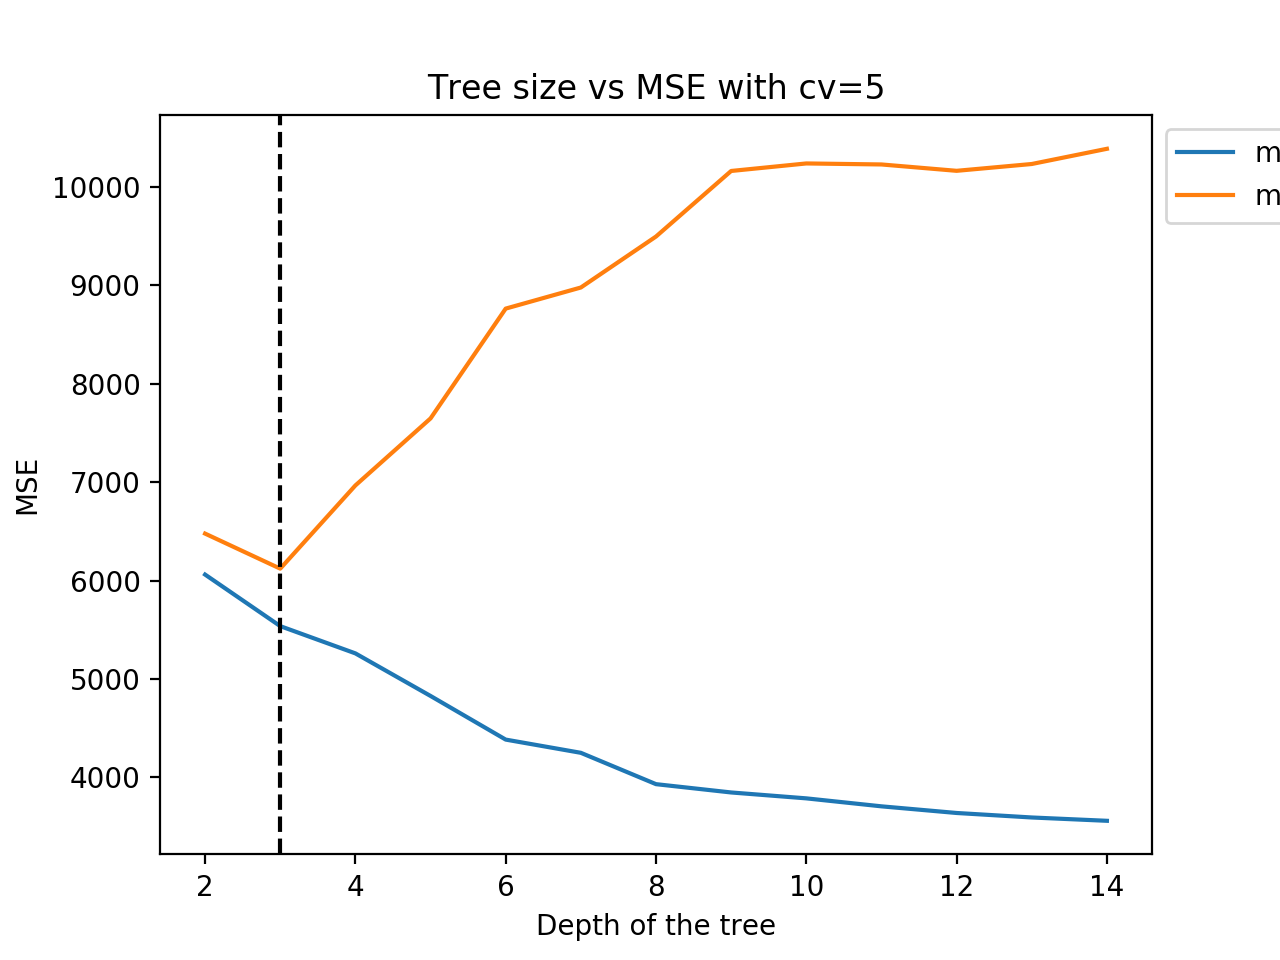

----------------------------------------------------------------


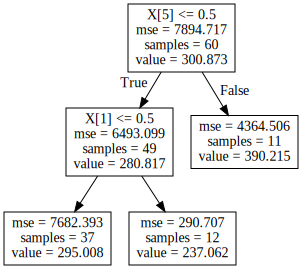

<IPython.core.display.Javascript object>


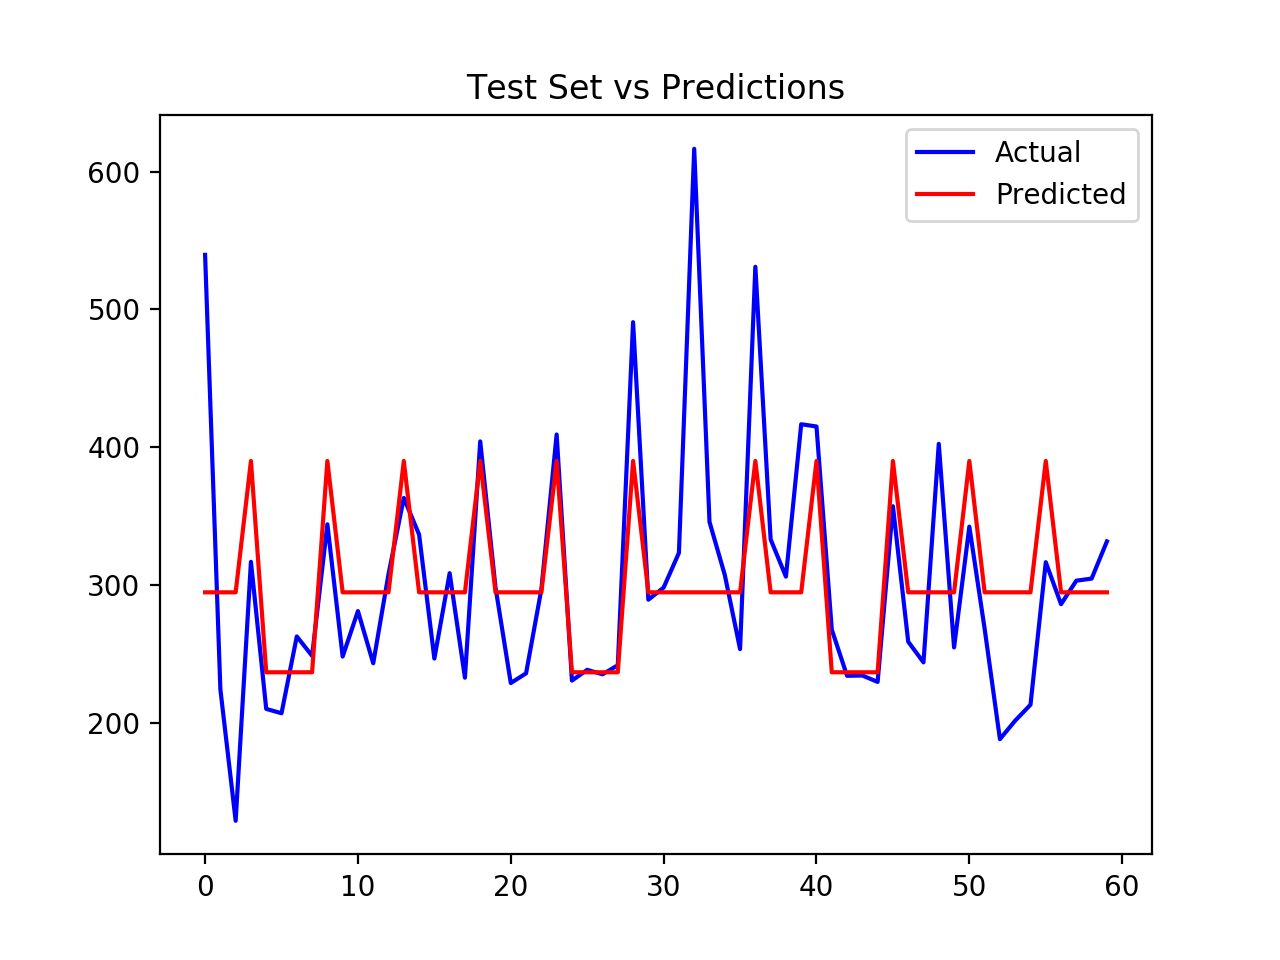

MSE: 5595.776447970857
R2: 0.2911998634404118


In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source

dt_reg = DecisionTreeRegressor(criterion="mse", splitter="best")
# param_grid = {"max_depth":list(range(3, 11)), 
#               "min_samples_leaf":range(5, 10)}
param_grid = {"max_leaf_nodes":range(2, 15)}
grid_search = GridSearchCV(estimator=dt_reg, 
                           param_grid=param_grid, 
                           scoring=make_scorer(mean_squared_error), 
                           n_jobs=-1, 
                           cv=5, 
                           return_train_score=True)
grid_search.fit(X_encoded, y)
cv_result = pd.DataFrame(grid_search.cv_results_)
plt.plot(cv_result["param_max_leaf_nodes"], cv_result["mean_train_score"], label="mean_train_score")
plt.plot(cv_result["param_max_leaf_nodes"], cv_result["mean_test_score"], label="mean_test_score")
plt.xlabel("Depth of the tree")
plt.ylabel("MSE")
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Tree size vs MSE with cv=5")
plt.axvline(3, color='k', linestyle='dashed')
plt.show()
print("----------------------------------------------------------------")
dt_reg = DecisionTreeRegressor(criterion="mse", splitter="best", max_leaf_nodes=3)
dt_reg.fit(X_encoded, y)
graph = Source(tree.export_graphviz(dt_reg, out_file=None))
display(SVG(graph.pipe(format='svg')))
y_pred = dt_reg.predict(X_encoded)
x = list(range(y.shape[0]))
plt.figure()
plt.plot(x, y, "b")
plt.plot(x, y_pred, "r")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])
plt.show()
print("MSE: {}\nR2: {}".format(mean_squared_error(y, y_pred), r2_score(y, y_pred)))

### Bagging: Decision Tree 

/Users/burakonal/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


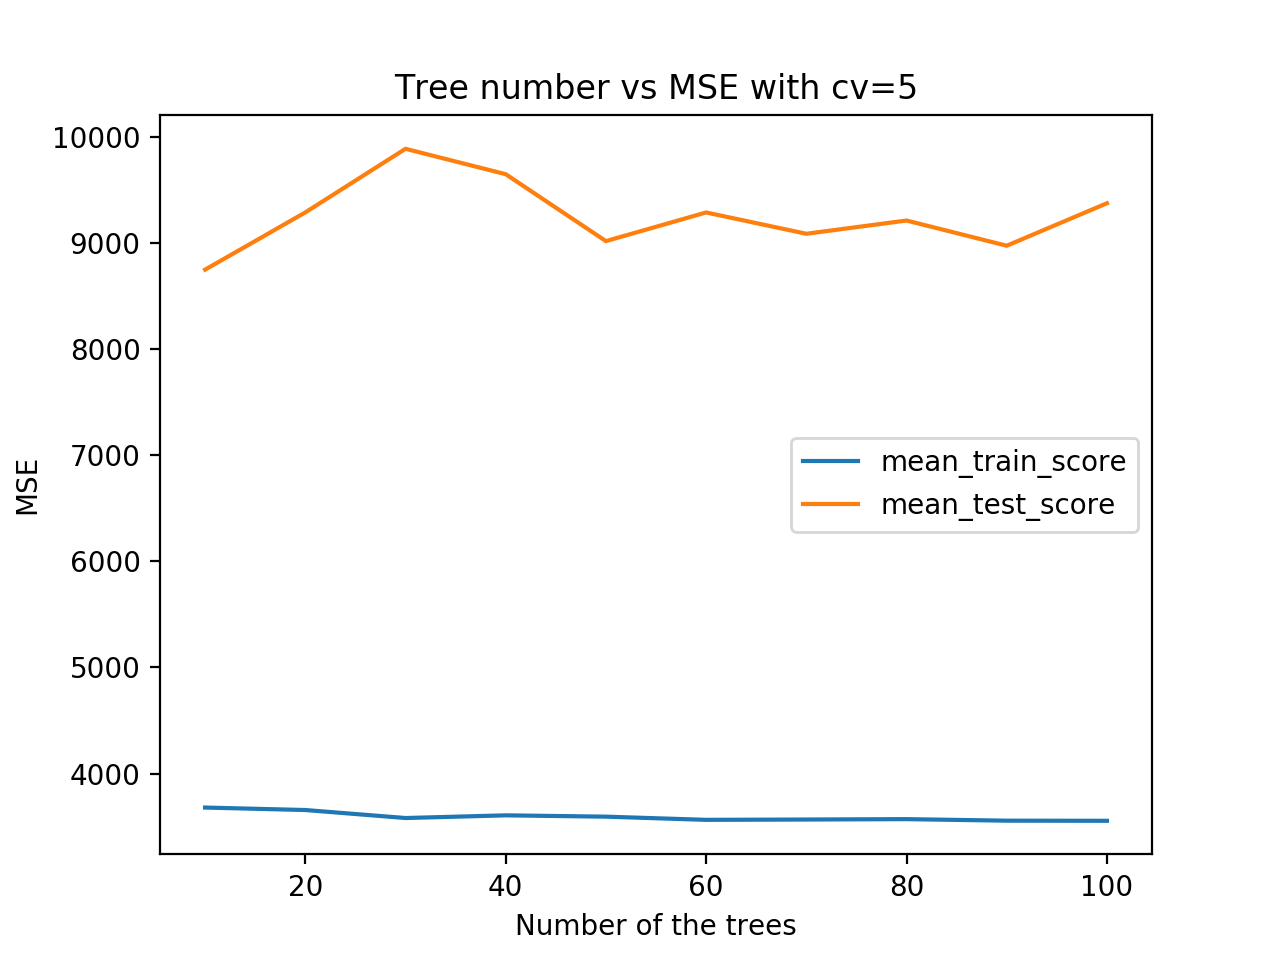

----------------------------------------------------------------


/Users/burakonal/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


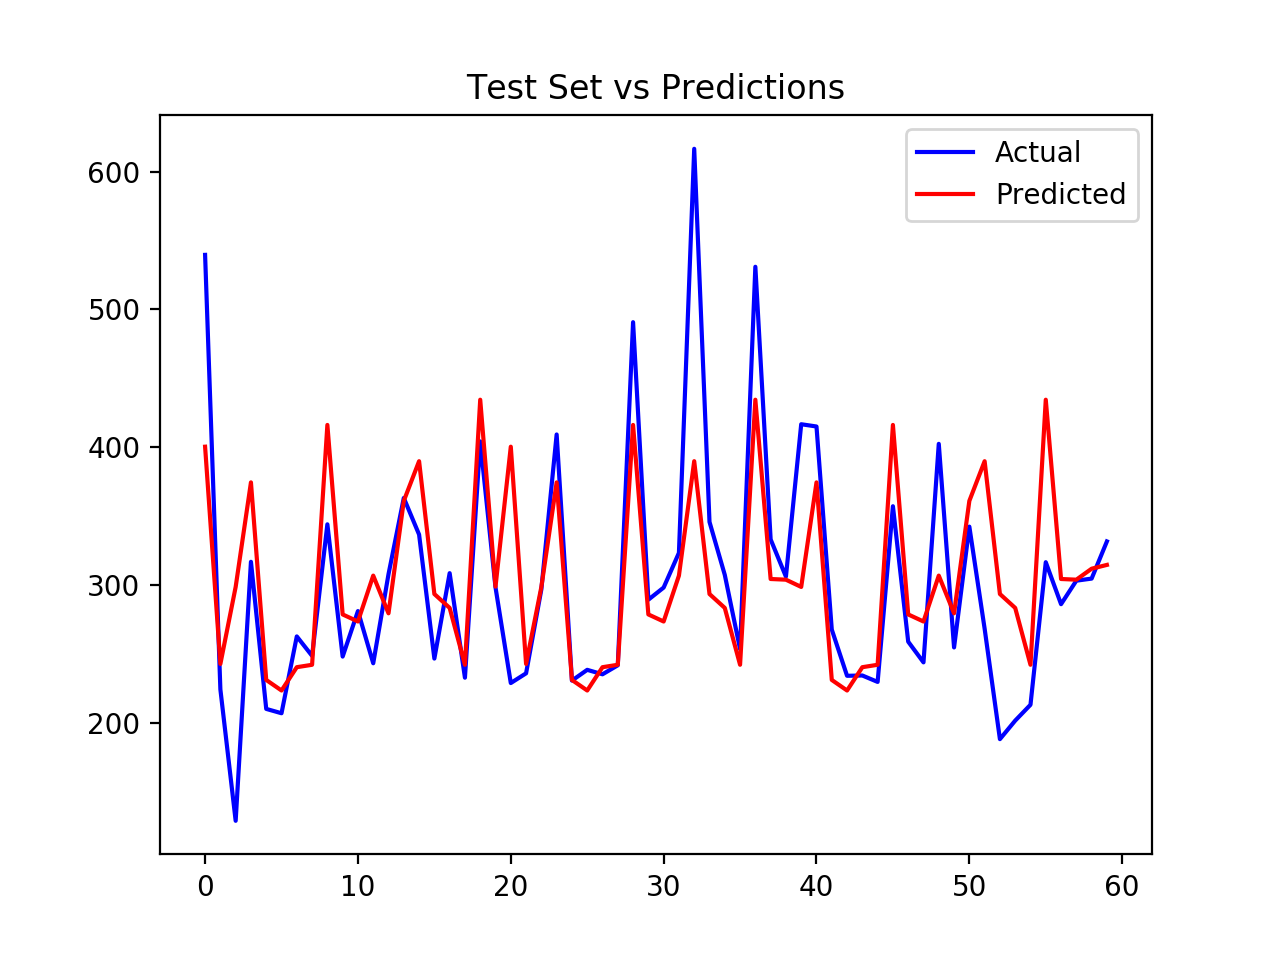

MSE: 4211.393468759266
R2: 0.46655548277930914


In [40]:
from sklearn.ensemble import BaggingRegressor
bg_dt_regressor = BaggingRegressor()
param_grid = {"n_estimators":range(10, 110, 10)}
grid_search = GridSearchCV(estimator=bg_dt_regressor, 
                           param_grid=param_grid, 
                           scoring=make_scorer(mean_squared_error), 
                           n_jobs=-1, 
                           cv=5, 
                           return_train_score=True)
grid_search.fit(X_encoded, y)
cv_result = pd.DataFrame(grid_search.cv_results_)
plt.plot(cv_result["param_n_estimators"], cv_result["mean_train_score"], label="mean_train_score")
plt.plot(cv_result["param_n_estimators"], cv_result["mean_test_score"], label="mean_test_score")
bt_dt_regressor_cv = cv_result["mean_test_score"]
plt.xlabel("Number of the trees")
plt.ylabel("MSE")
plt.legend()
plt.title("Tree number vs MSE with cv=5")
plt.show()
print("----------------------------------------------------------------")
bg_dt_regressor = BaggingRegressor(n_estimators=20)
bg_dt_regressor.fit(X_encoded, y)
y_pred = bg_dt_regressor.predict(X_encoded)
x = list(range(y.shape[0]))
plt.figure()
plt.plot(x, y, "b")
plt.plot(x, y_pred, "r")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])
plt.show()
print("MSE: {}\nR2: {}".format(mean_squared_error(y, y_pred), r2_score(y, y_pred)))

### Random Forest
Ref: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

/Users/burakonal/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


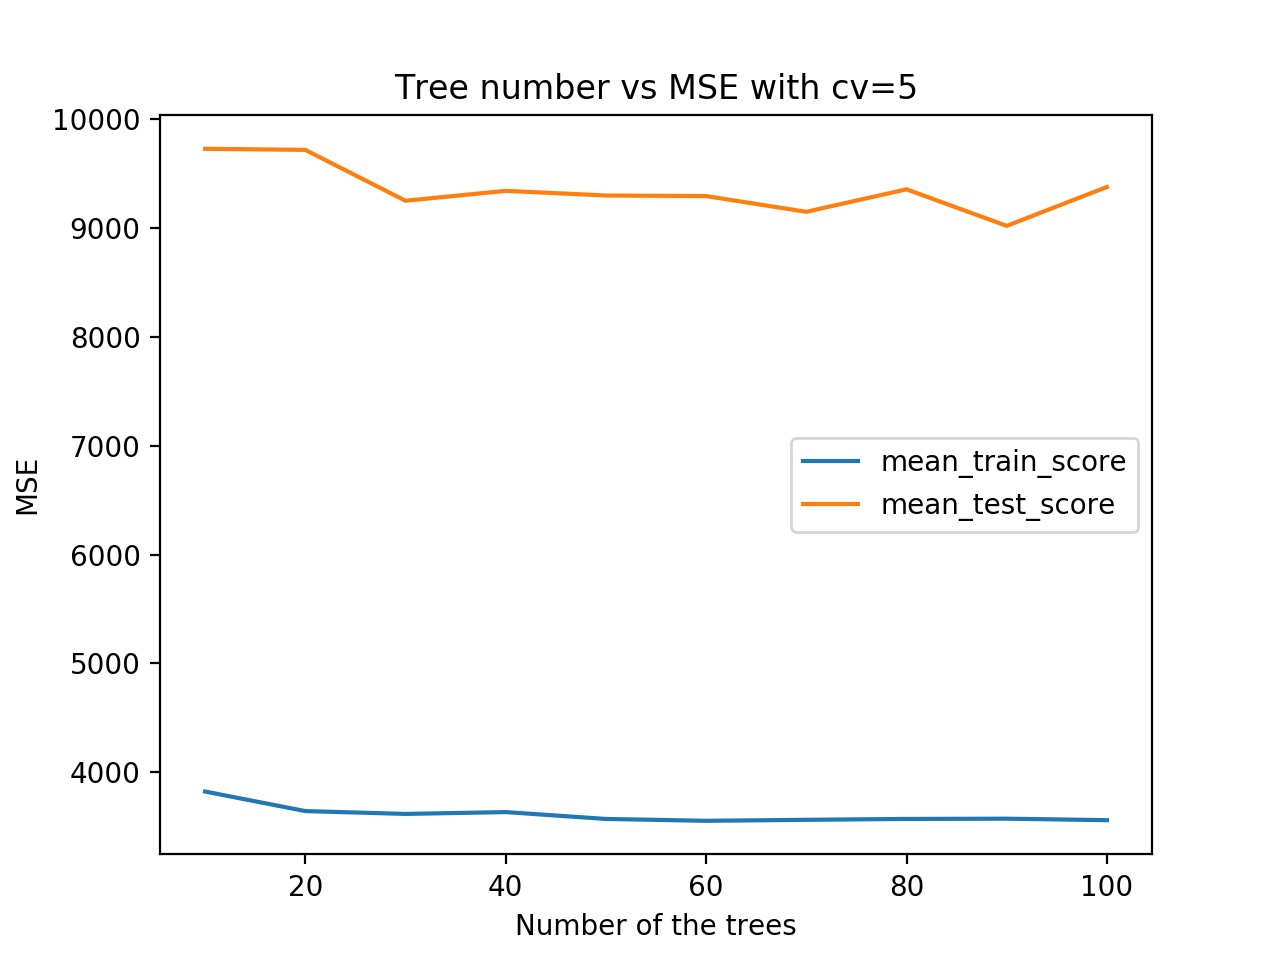

----------------------------------------------------------------


/Users/burakonal/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


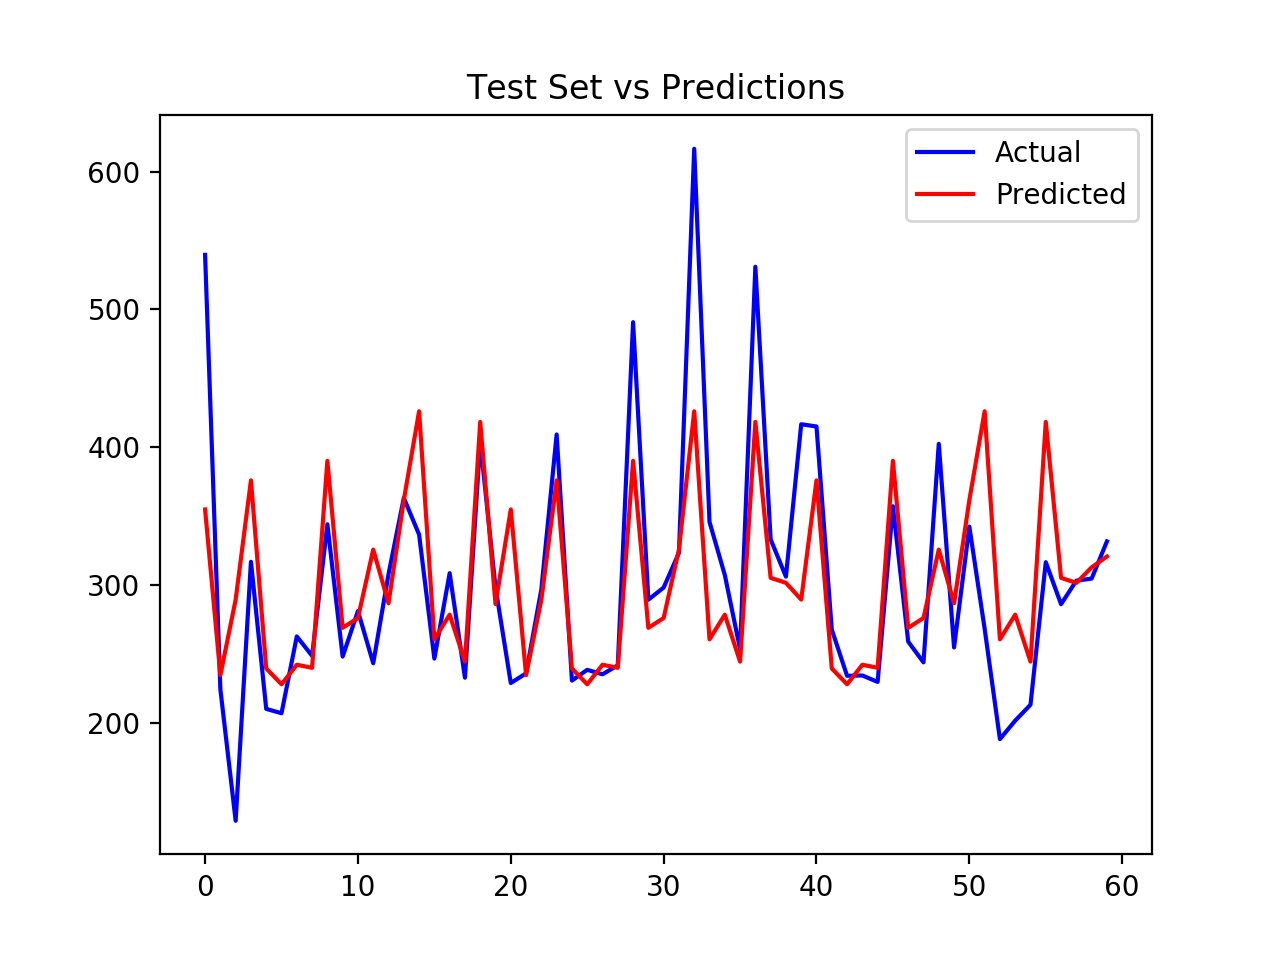

MSE: 4108.602643967284
R2: 0.4795756867361791


<IPython.core.display.Javascript object>


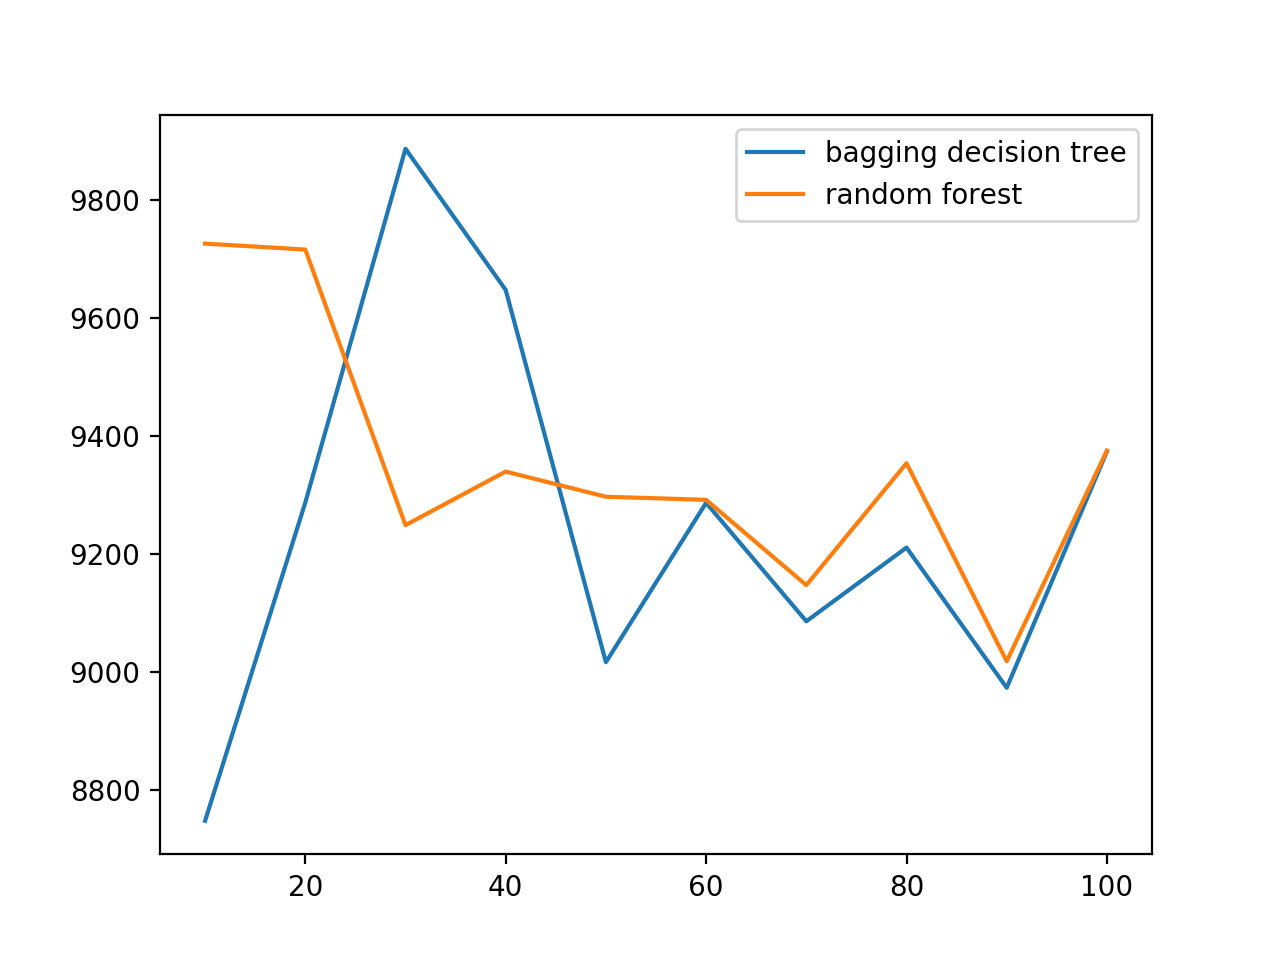

In [41]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor()
# rf_reg.get_params()
param_grid = {"n_estimators":range(10, 110, 10)}
grid_search = GridSearchCV(estimator=rf_regressor,
                           param_grid=param_grid, 
                           scoring=make_scorer(mean_squared_error), 
                           n_jobs=-1, 
                           cv=5, 
                           return_train_score=True)
grid_search.fit(X_encoded, y)
cv_result = pd.DataFrame(grid_search.cv_results_)
plt.plot(cv_result["param_n_estimators"], cv_result["mean_train_score"], label="mean_train_score")
plt.plot(cv_result["param_n_estimators"], cv_result["mean_test_score"], label="mean_test_score")
rf_regressor_cv = cv_result["mean_test_score"]
plt.xlabel("Number of the trees")
plt.ylabel("MSE")
plt.legend()
plt.title("Tree number vs MSE with cv=5")
plt.show()
print("----------------------------------------------------------------")
rf_regressor = BaggingRegressor(n_estimators=30)
rf_regressor.fit(X_encoded, y)
y_pred = rf_regressor.predict(X_encoded)
x = list(range(y.shape[0]))
plt.figure()
plt.plot(x, y, "b")
plt.plot(x, y_pred, "r")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])
plt.show()
print("MSE: {}\nR2: {}".format(mean_squared_error(y, y_pred), r2_score(y, y_pred)))


plt.plot(cv_result["param_n_estimators"], bt_dt_regressor_cv, label="bagging decision tree")
plt.plot(cv_result["param_n_estimators"], rf_regressor_cv, label="random forest")
plt.legend()
plt.show()

/Users/burakonal/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


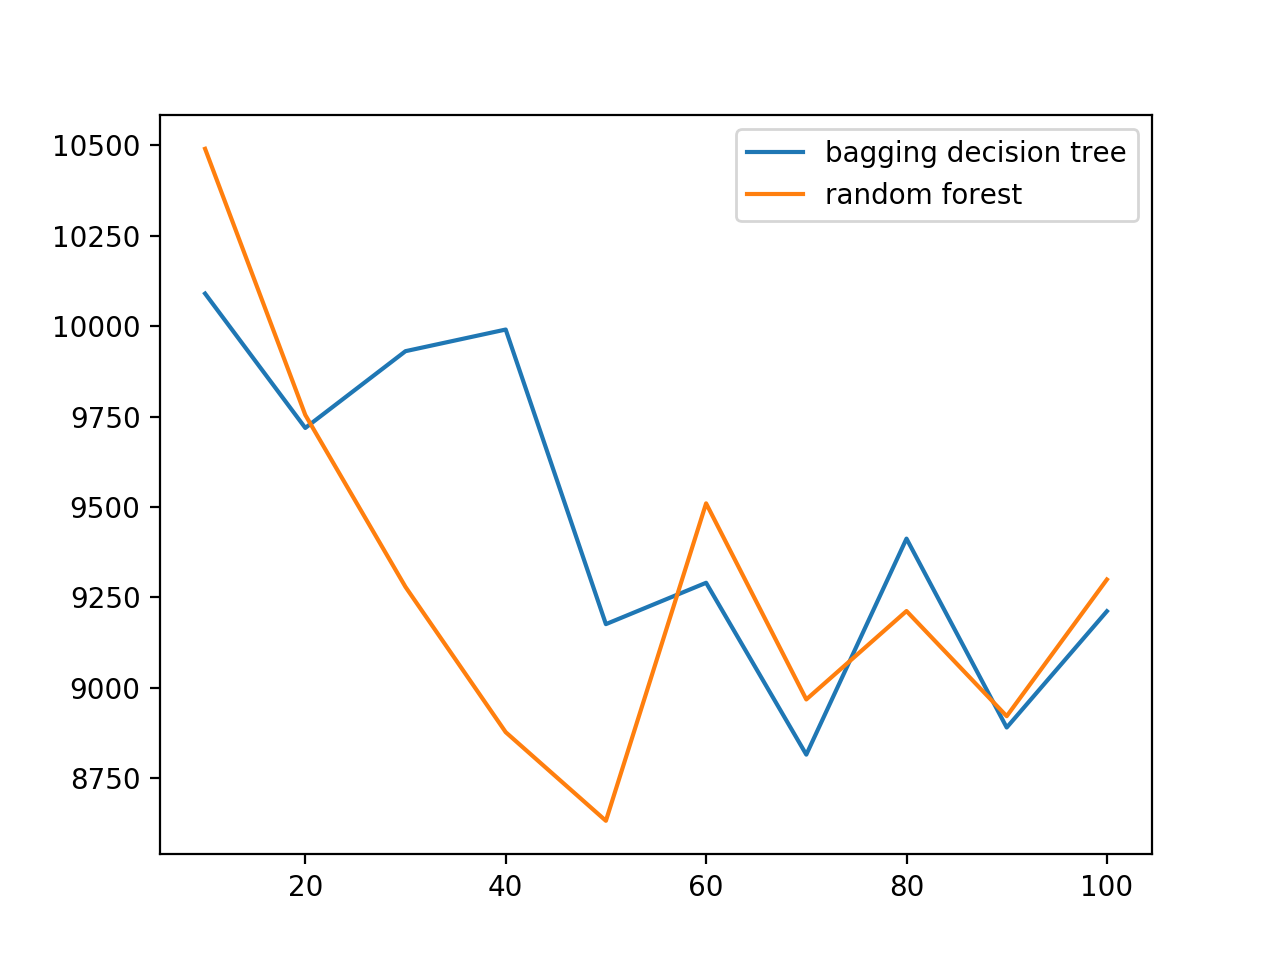

In [39]:
plt.plot(cv_result["param_n_estimators"], bt_dt_regressor_cv, label="bagging decision tree")
plt.plot(cv_result["param_n_estimators"], rf_regressor_cv, label="random forest")
plt.legend()
plt.show()

### MLP Regressor
Ref: http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor()
# mlp_reg.get_params()
X_train, X_test, y_train, y_test = train_test_split(data_encoded, y, test_size=0.2, random_state=42)
param_grid = {"hidden_layer_sizes": [(100,), (200,), (300,), (400,), (500,), (600,), (700,), (800,), (900,), (1000,)], 
              "alpha": [0.001, 0.0001, 0.00001]}
grid_search = GridSearchCV(estimator=mlp_reg, 
                           param_grid=param_grid, 
                           scoring=make_scorer(mean_squared_error), 
                           n_jobs=-1, 
                           cv=loo, 
                           refit=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
mlp_reg_y = pd.DataFrame(grid_search.predict(X_test), columns=[y.columns[0]])
print("MSE of the mlp regressor: {:.3f}".format(mean_squared_error(y_test, mlp_reg_y)))
print("R2 of the mlp regressor: {:.3f}".format(r2_score(y_test, mlp_reg_y)))
x = list(range(y_test.shape[0]))
plt.plot(x, y_test, "bo")
plt.plot(x, mlp_reg_y, "rx")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])

### Comments
* The data set is too small. There are 60 rows of the data.
* The best performing methods are ensemble learning: bagging with decision tree and random forest. 

### What can be done further
* Futher feature engineering
* Boosting.
* A more extensive grid search for tree based models.
* Outlier elimination; although losing samples out of an already limited number of samples is questionable.